# SIRV model

This is the SIR epidemiology model with vaccination. 
It is based on a set of differential equations:
$$
\begin{align}
\frac{dS}{dt} & = -rIS - fS + g_r R +g_v V \\
\frac{dI}{dt} & = rIS - aI \\
\frac{dR}{dt} & = aI -fR - g_r R \\
\frac{dV}{dt} & = f(S+R) - g_v V
\end{align}
$$

| Label | Description                                                   |  
| :---- | :------------------------------------------------------------ |  
| $S$   | Proportion of the population who are susceptible              |  
| $I$   | Proportion of the population who are infected                 |  
| $R$   | Proportion of the population who are immune after recovery    |  
| $V$   | Proportion of the population who are immune after vaccination |  

| Parameter | Description                                                                                                |  
| :-------- | :--------------------------------------------------------------------------------------------------------- |  
| $r$       | Controls transmission between infected and susceptible population                                          |  
| $a$       | Recovery rate of the infected population. $\frac{1}{a}$ gives the average contagious duration.             |  
| $g_r$     | Rate at which immunity is lost after recovery. $\frac{1}{g_r}$ gives the average duration of immunity.     |  
| $g_v$     | Rate at which immunity is lost after vaccination. $\frac{1}{g_v}$ gives the average duration of immunity . |   

In order for the pandemic to stop, we need the number of infected people to decrease over time, i.e. we need $\frac{dI}{dt}<0$. From the equation for $\frac{dI}{dt}$, we can obtain
$$
\begin{align}
\frac{dI}{dt} & = rIS - aI \\
     & = aI (\frac{rS}{a} - 1) \\
     & = aI (\mathbf{R} - 1) \text{, where }\mathbf{R}=\frac{rS}{a} \\
\end{align}
$$

For $\frac{dI}{dt}<0$, we need $\mathbf{R}<1$.

This $\mathbf{R}$ is know as the **reproduction number**. It is the average number of people one infected person will transmit the disease to. It is dependent on the transmission rate $r$, recovery rate $a$ and the proportion of the population still susceptible to the disease $S$.

In this notebook, we consider three different defintions of $\mathbf{R}$:

| Reproduction number | Condition |
| :-- | :-- |
| $R_0$ | Basic reproduction number. Start of the epidemic. Everyone is susceptible and no control measures |
| $R_\text{eff}$ | Effective reproduction number. Can be adjusted by implemented or removing control measures |
| $R_\text{normal}$ | Reproduction number if all control measures were removed. Dependent only on the proportion of susceptible people. |

The basic reproduction number, ${R}=R_0$, tell us how quickly a disease would spread at the start of the pandemic: if no measures are taken to stem the spread of the disease and the entire population is still susceptible ($S=1$), then each infected person would spread it to $R_0$ of their susceptible contacts. It was estimated that $R_0 \approx 3$ for COVID-19. 

The effective reproduction number, ${R}_\text{eff}$, can be controlled by social distancing measures (which reduces $r$). By reducing this, we can control how quickly the disease spreads. 

Finally, ${R}_\text{normal}$ is what the reproduction number would be if all social distancing measures were removed. This is dependent on the number of people susceptible $S$ and ${R}_0$: ${R}_\text{normal} = {R}_0 \cdot S$. If $S$ is small enough such that ${R}_\text{normal}<1$, then we can return to normal life without fear of a new large outbreak. 

In [1]:
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from IPython.display import display, HTML
pd.options.display.float_format = '{:,.4f}'.format

In [21]:
population_size = 66e6

def SIRV_evolution(x0, R0=3, Reff=3, f=0, gr=0, gv=0):
    S, I, R, V, It, _, _ = x0
    a = 0.5 if duration_unit == "Weeks" else 2
    if Reff<0: Reff=Rnormal(S, R0)
    Reff = min(Reff, R0)
    r =  Reff*a/S if S>0 else 0 #R = r*S/a  => r= Reff* a/S
    
    f_eff = f/(S+R) if ((S+R)>0 and f/(S+R) < 1) else 1
    dx = [-r*I*S -f_eff*S+ gr*R + gv*V,   # dS
          r*I*S - a*I,                    # dI
          a*I - f_eff*R - gr*R,           # dR
          f_eff*(S+R)-gv*V,               # dV
          r*I*S,                          # dI(tot)
          0, 0
         ]
    x1 = x0 + dx
    x1[0:4] = np.minimum(np.maximum(x1[0:4], np.zeros(4)), np.ones(4))
    x1[-2] = Rnormal(S, R0)
    x1[-1] = Reff
    return x1

def Rnormal(S=1, R0=3):
    return S*R0

def plotResults(SIRV, showS=True, showV=True, logy=False, wholeTable=False, legendloc=0, magnifyInfected=1):
    f, axs = plt.subplots(1,3,figsize=(18,4))
    plt.subplots_adjust(wspace=0.45)
    
    population_unit = ""
    effective_population = population_size
    if population_size > 10e6:
        effective_population = population_size / 1e6
        population_unit = "(millions)"

    ax1 = axs[0]
    for ii in range(0 if showS else 1, 4 if showV else 3):
        ax1.plot(range(duration), 
                 np.multiply(SIRV.iloc[:,ii],magnifyInfected) if (ii==1) else SIRV.iloc[:,ii],
                 label=labels[ii] + ((" (x{})".format(magnifyInfected)) if (ii==1 and magnifyInfected!=1) else ""), 
                 color=colors(ii), linestyle="dashed" if (ii==1 and magnifyInfected!=1) else "solid");
    ax1.legend(loc=legendloc)
    ax1.set_xlabel(duration_unit)
    ax1.set_ylabel("Proportion of population")
    if logy: 
        ax1.set_yscale('log')
    else: 
        ax1a = ax1.twinx()
        ax1a.set_ylim(effective_population*ax1.get_ylim()[0], effective_population*ax1.get_ylim()[1])
        ax1a.set_ylabel("Number of people {}".format(population_unit))

    ax2 = axs[1]
#     ax2.plot(0, 1, duration-1, 1, ":r")
    ax2.plot(range(duration), np.ones(duration), "k:")
    ax2.text(duration*0.75, 1.03, "R=1")
    ax2.plot(range(duration), SIRV["Rnormal"], color=cm.get_cmap("Dark2")(0), label="$R_{normal}$")
    ax2.plot(range(duration), SIRV["Reff"], color=cm.get_cmap("Dark2")(1), label="$R_{eff}$", linestyle='dotted')
    ax2.set_xlabel(duration_unit)
    ax2.set_ylabel("$R$")
    ax2.legend()
    ax2.plot(1, 1, duration-1, 1)

    ax3 = axs[2]
    ax3.plot(range(duration), SIRV["Total infected"], label="Total infected", color=cm.get_cmap("Accent")(0));
#     forLabel = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    ax3.plot(0, SIRV["Total infected"][0], visible=False,
             label="{:,.0f} additional cases".format(
                    population_size*(SIRV["Total infected"][duration-1] - SIRV["Total infected"][0])))
    ax3.plot(0, SIRV["Total infected"][0], visible=False,
         label="by {} {}".format(duration, duration_unit))
    ax3.legend(loc='lower right')
    ax3.set_xlabel(duration_unit)
    ax3.set_ylabel("Proportion of population")
    ax3a = ax3.twinx()
    ax3a.set_ylim(effective_population*ax3.get_ylim()[0], effective_population*ax3.get_ylim()[1])
    ax3a.set_ylabel("Number of people {}".format(population_unit))

    if wholeTable:
        display(HTML(SIRV.to_html()))
    else:
        idxs = [0, 1, 2]
        if len(SIRV.query('Rnormal < 1'))>0:
            idxs = idxs + [ SIRV.query('Rnormal > 1').idxmin()['Rnormal'], 
                            SIRV.query('Rnormal < 1').idxmax()['Rnormal'] ]
        idxs = idxs + [-3, -2, -1]
        display(HTML(SIRV.iloc[idxs].to_html()))
    print("Additional infections = {:,.0f}".format(population_size*(SIRV.iloc[-1, 4] - SIRV.iloc[0,4])))


labels = ["Susceptible", "Infected", "Recovered", "Vaccinated", "Total infected", "Rnormal", "Reff"]
colors = cm.get_cmap("tab10")

def runEvolution(SIRV0, unlock=False, **conditions):
    SIRV = pd.DataFrame(np.zeros([duration, 7]), columns=labels)
    SIRV.index.name = duration_unit
    SIRV0.append(Rnormal(SIRV0[0]))
    SIRV0.append(Rnormal(SIRV0[0]) if conditions.get("Reff", -1) <0 else conditions.get("Reff", Rnormal(SIRV0[0])))
    SIRV.iloc[0] = SIRV0
    if duration_unit == "Weeks":
        if conditions.get('f', None) is not None: conditions["f"] = conditions["f"]/4
        if conditions.get("gr", None) is not None: conditions["gr"] = conditions["gr"]/4
        if conditions.get("gv", None) is not None: conditions["gv"] = conditions["gv"]/4
    for ii in range(1, np.shape(SIRV)[0]):
        if unlock and SIRV.iloc[ii-1]["Rnormal"]<1:
            conditions["Reff"]=-1
        SIRV.iloc[ii] = SIRV_evolution(SIRV.iloc[ii-1], **conditions)
    return SIRV

Additional infections = 202,283,862


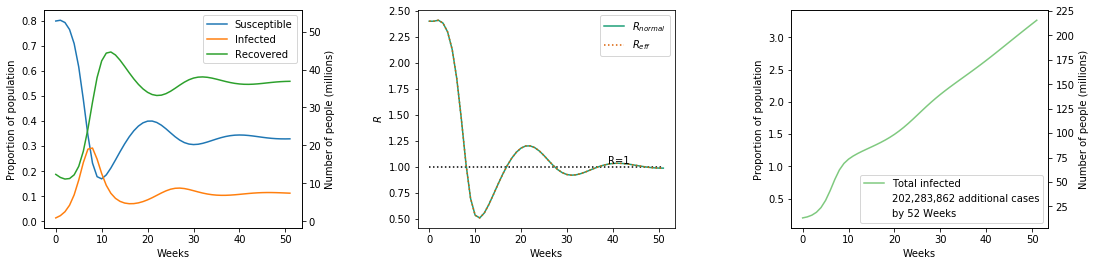

In [29]:
duration, duration_unit = 52 , "Weeks" 
# duration, duration_unit = 24   , "Months" 

## Set up initial conditions
I0 = 0.013 # 60k per day for 14 days  # Initial infected proportion
It0 = .2                             # Initial cumulative infections 
R0 = It0 - I0                         # Initial recoverd proportion
V0 = 0                                # Initial vaccinated proportion
S0 = 1 - I0 - R0 - V0                 # Initial susceptible proportion

conditions = {
#     Basic R number
    "R0": 3,
    
#     Effective R number
#     "Reff": 2,
    "Reff": -1, # Reff = -1 for no restrictions
    
#     Vaccination rate per month
#     "f": 0.1,
    
#     1 / (average time in months to lose immunity after recovery)
    "gr": 1/2.5, 
    
#     1 / (average time in months to lose immunity after vaccination) 
#     "gv": 1/18,
       
#     Remove social distancing after Rnormal < 1
    "unlock": True,
}

plotting_options = {
#     "wholeTable": True, 
#     "showS": False,
    "showV": False,
#     "magnifyInfected": 10
#     "legendloc": "lower right"
}

## Evolve
SIRV = runEvolution([S0, I0, R0, V0, It0], **conditions)
plotResults(SIRV, **plotting_options)